<a href="https://colab.research.google.com/github/adundulis/stable-diffusion/blob/main/lora_stable_diffusion_wrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoRA Stable Diffusion

In [ ]:
#@markdown # Setup LoRA, Dependencies and Mount Google Drive

from IPython.utils import capture
import sys
import os
import time

SESSION_NAME = "char" #@param{type: 'string'}

if SESSION_NAME == "":
  raise SystemExit('SESSION_NAME should not be empty.')

print('Mounting Google Drive...')
with capture.capture_output() as cap:
  from google.colab import drive
  drive.mount('/content/gdrive')

print('Installing LoRA and Dependencies...')
with capture.capture_output() as cap:
  !git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
  !pip install accelerate bitsandbytes

print('Intialising Session Workspace...')
WORKSPACE='/content/gdrive/MyDrive/lora-stable-difussion'
SESSION_DIR = WORKSPACE + '/sessions/' + SESSION_NAME
IMAGES_DIR = SESSION_DIR + '/images'
CAPTIONS_DIR = SESSION_DIR + '/captions'
MODELS_DIR = SESSION_DIR + '/models'

with capture.capture_output() as cap:
  %cd /content
  if not os.path.exists(str(SESSION_DIR)):
    %mkdir -p $SESSION_DIR
    time.sleep(1)
  if not os.path.exists(str(IMAGES_DIR)):
    %mkdir -p $IMAGES_DIR
    time.sleep(1)
  if not os.path.exists(str(CAPTIONS_DIR)):
    %mkdir -p $CAPTIONS_DIR
    time.sleep(1)
  if not os.path.exists(str(MODELS_DIR)):
    %mkdir -p $MODELS_DIR
    time.sleep(1)

print('\033[92m' + 'Initialisation Successful' + '\033[0m')

In [7]:
#@markdown # Upload Images and Captions

import shutil
from google.colab import files
from IPython.display import display, clear_output

UPLOAD_IMAGES = True #@param{type: 'boolean'}
UPLOAD_CAPTIONS = True #@param{type: 'boolean'}
REMOVE_EXISTING_IMAGES = True #@param{type: 'boolean'}
REMOVE_EXISTING_CAPTIONS = True #@param{type: 'boolean'}

if REMOVE_EXISTING_IMAGES:
  if os.path.exists(str(IMAGES_DIR)):
    !rm -r "$IMAGES_DIR"
if not os.path.exists(str(IMAGES_DIR)):
  %mkdir -p "$IMAGES_DIR"

if REMOVE_EXISTING_CAPTIONS:
  if os.path.exists(str(CAPTIONS_DIR)):
    !rm -r "$CAPTIONS_DIR"
if not os.path.exists(str(CAPTIONS_DIR)):
  %mkdir -p "$CAPTIONS_DIR"

print('Upload Images')
uploaded_images = files.upload()
for filename in uploaded_images.keys():
  shutil.move(filename, IMAGES_DIR)

clear_output(wait=True)

print('Upload Captions')
uploaded_captions = files.upload()
for filename in uploaded_captions.keys():
  shutil.move(filename, CAPTIONS_DIR)

clear_output(wait=True)

print('\033[92m' + 'Upload Completed' + '\033[0m')

Upload Completed


In [8]:
PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="ktn" #@param{type: 'string'}

OUTPUT_DIR="" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

STEPS = 300 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 3e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-5 #@param {type:"number"}


if os.path.exists(str(MODELS_DIR)):
    !rm -r "$MODELS_DIR"

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"


  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{IMAGES_DIR}" '
             f'--output_dir="{MODELS_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER} '
             f'--external_captions '
             f'--captions_dir={CAPTIONS_DIR}')
  
!rm -rf $IMAGES_DIR/.ipynb_checkpoints
!{command}

2023-05-21 16:40:43.462261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
Before training: Unet First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Before training: Unet First Layer lora down tensor([[ 0.0423,  0.0892,  0.0594,  ...,  0.0150, -0.0294,  0.0119],
        [ 0.0287, -0.0437,  0.0138,  ...,  0.0162,  0.0089, -0.0365],
        [ 0.0019,  0.0629, -0.0268,  ...,  0.0390, -0.0247,  0.0093],
        ...,
        [ 0.0021, -0.0607, -0.0290,  ...,  0.0736, -0.0743,  0.0198],
        [-0.0305, -0.0471,  0.

In [17]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(MODELS_DIR, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(MODELS_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(MODELS_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])
pipe.safety_checker = None

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:1039 in            │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   1036 │   │   │   │   loaded_sub_model = passed_class_obj[name]                                 │
│   1037 │   │   │   else:                                                                         │
│   1038 │   │   │   │   # load sub model                                                          │
│ ❱ 1039 │   │   │   │   loaded_sub_model = load_sub_model(                                        │
│   1040 │   │   │   │   │   library_name=library_name,                                            │
│   1041 │   │   │   │   │   class_name=class_name,                                                │
│   1042 │   │   │   │   │   importable_classes=importable_classes,                                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:448 in             │
│ load_sub_model                                                                                   │
│                                                                                                  │
│    445 │   │   loaded_sub_model = load_method(os.path.join(cached_folder, name), **loading_kwar  │
│    446 │   else:                                                                                 │
│    447 │   │   # else load from the root directory                                               │
│ ❱  448 │   │   loaded_sub_model = load_method(cached_folder, **loading_kwargs)                   │
│    449 │                                                                                         │
│    450 │   return loaded_sub_model                                                               │
│    451                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:494 in                │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   491 │   │   }                                                                                  │
│   492 │   │                                                                                      │
│   493 │   │   # load config                                                                      │
│ ❱ 494 │   │   config, unused_kwargs, commit_hash = cls.load_config(                              │
│   495 │   │   │   config_path,                                                                   │
│   496 │   │   │   cache_dir=cache_dir,                                                           │
│   497 │   │   │   return_unused_kwargs=True,                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:350 in load_config      │
│                                                                                                  │
│   347 │   │   │   ):                                                                             │
│   348 │   │   │   │   config_file = os.path.join(pretrained

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

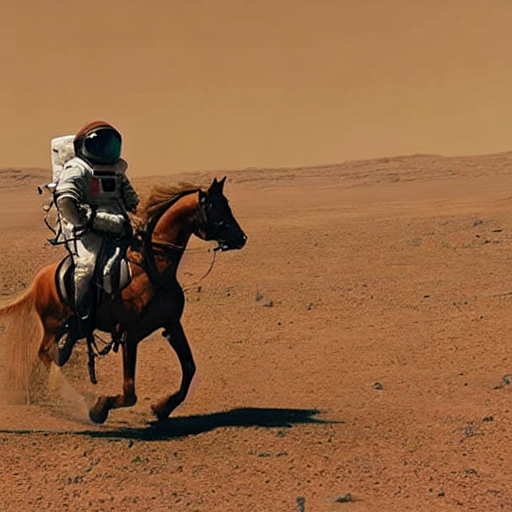

In [14]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]  
    
image.save("astronaut_rides_horse.png")
image